In [3]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [12]:
path = '/home/kebl7383/claim-matching-robustness/experiments/mitigation/gpt4o/ood-dataset/orig_ood_normalised.jsonl'

In [13]:
parsed_df = pd.read_json(path, lines=True)

In [18]:
def parse_normalised_claim(row):
    """
    Parses the normalised claim string to extract the claim content.
    If parsing fails, returns the original query from the row.

    Args:
        row (pd.Series): A row of the DataFrame containing 'normalised' and 'query'.

    Returns:
        str: The extracted claim content or the original query if parsing fails.
    """
    input_string = row['normalised']
    
    try:
        if isinstance(input_string, str) and input_string.startswith("Normalised Claim:"):
            # Remove the prefix and trim whitespace
            claim = input_string[len("Normalised Claim:"):].strip()
            # Remove surrounding quotes if they exist
            if claim.startswith('"') and claim.endswith('"'):
                claim = claim[1:-1]
            return claim
    except Exception:
        pass  # Handle unexpected errors silently

    # If parsing fails, return the original query
    return row['query']

# Apply function using DataFrame row-wise processing
parsed_df['normalised_claim'] = parsed_df.apply(parse_normalised_claim, axis=1)

In [19]:
parsed_df.head()

,query_id,query,normalised,normalised_claim
0,"376,986","#BREAKING_NEWS\n\nAnil Ambani's tremendous attack on Rahul Gandhi\n\n A man, not worth a pinch off salt, whose family has always robbed the country, denounces me in every election meeting,\n\nI want to ask him some questions today, hopefully the media will ask off him the answers.\n\n(1) My family and my myself pay tax of 50000+ crores rupees every year to the country. Pay Millions of people, salaries every month, help in running the livelihood of millions of families.\n\nHow much money does Gandhi family contribute to this country ????\n\nI have heard that the whole family has been released on bail, by a court, in a case of tax evasion. Your mother has, reportedly become the fourth richest woman in the world. How has shape become so ? Is it by robbing CRORES, through CORRUPTION ? \nWould appreciate if you let all INDIAN’s & me know, the business, that your Mother owns & runs, for her to have accumulated, such immense wealth ? Pls reply....\n\n(2) We have been taking loans from banks for the last about 40 years and have payed / are still paying CRORES as interest, payed back the full loan & retaken, new Loans for new business opportunities, all businessmen & industrialists, across the world, without exception, have to, if they want to run any business. We also give guarantees & collateral to the Banks, for atleast, their basic safety, the interest that we pay, allow banks to pat the salaries and interest on all the deposits that the Banks have received from crores off depositer’s & account holders off theirs.\nTell me how leaders like you and people like your brother-in-law have got a interest-free loan’s from Bank’s ??? What business is he in, that gets him such privileges ???\nIn which country does these businesses run ??\nFrom which country & Banks has he received such loans from ?\n\n(3) As widely publicised, how has your great brother-in-law, who started his business, with a paid up Capital off ₹ 1 lakh, 15 years ago, become owner of CRORES worth off hotels & property, which is running into hundreds off acres off land, all this in a mind boggling 10 years !! How was he able to get such large amounts off money, which was obviously needed to acquire such large tracts off land ? Where did your family get the money to buy & own 2 bungalows and 6 flats in London ???\n\nMy dear countrymen\nWhen I came to know that this family is a foreign agent, this party supports anti-nationalists. I have stopped giving donations to the Congress Party, since then they are after me, they are hellbent on defaming me.\n\nAnswering to some of allegations against me, my family & Company’s owned or run by my family, let me ask, a few pertinent questions, answers, of which, too, I would like to get from the Gandhi family, CONGRESS PARTY, \nwhy wasn’t the contract off the Delhi Airport Metro Project, The Mumbai Metro Project, not awarded to multiple well regarded, Government Company’s, but to private players & Pvt Company’s, by the Manmohan Singh led UPA Government, if that is valid, what is wrong, if my Company, was chosen as a partner, by Dassault. This agenda, is not only hurting me, personally, but also hurting our Country’s image, WORLDWIDE.\nEven In Delhi (formerly DESU) DVB's power supply contract, worth 1200 crores, was given to my Company by the Sheila Dixit Government in place of NTPC (government company) ... WHY ?\n\nBetween 2004 and 2014, why did the Congress government, at the Centre & multiple States give my company Reliance Infrastructure a total of 8 national highways and projects (worth 25350 crore) in Uttar Pradesh, Odisha, Tamil Nadu, Karnataka, Punjab ??\nWhile there are many government companies that could do this work ???\n\n""These are some aspects & truth that the public does not know & should know.""\n\nPlease copy paste and share and forward this information to the whole country & oblige.\nThankyou...🙏\n\nAnil Ambani\n\n(Message sent for fact-check)","Normalised Claim:

In [20]:
# Save the original claims
pd.DataFrame(parsed_df[['query_id', 'normalised_claim']]).to_csv(
    '/home/kebl7383/claim-matching-robustness/experiments/ood/ood-dataset/ood_normalised_queries.tsv',
    index=False,
    header=["query_id", "query"],
    sep="\t",
)

In [73]:
import matplotlib.pyplot as plt

# Prepare the data for plotting
data = {
    "Perturbation": ["Typos (Most)", "Dialect (Pidgin)", "Entity Replacement (All)"],
    "Unpertubed-LASER": [0.3925368375, 0.3762761346, 0.383623902],
    "Unpertubed-LASER+CN": [0.4692155375, 0.4272919467, 0.4487253053],
    "Perturbed-LASER": [0.327248736, 0.3307935937, 0.3221515615],
    "Perturbed-LASER+CN": [0.481794082, 0.4600243046, 0.3968193758],
    "Unpertubed-RoLASER": [0.4048508585, 0.3883688138, 0.4164909542],
    "Unpertubed-RoLASER+CN": [0.4239301394, 0.3980654122, 0.4168946832],
    "Perturbed-RoLASER": [0.3511871528, 0.3336198569, 0.3129087056],
    "Perturbed-RoLASER+CN": [0.4797898815, 0.4129593157, 0.3616379534]
}

df = pd.DataFrame(data)

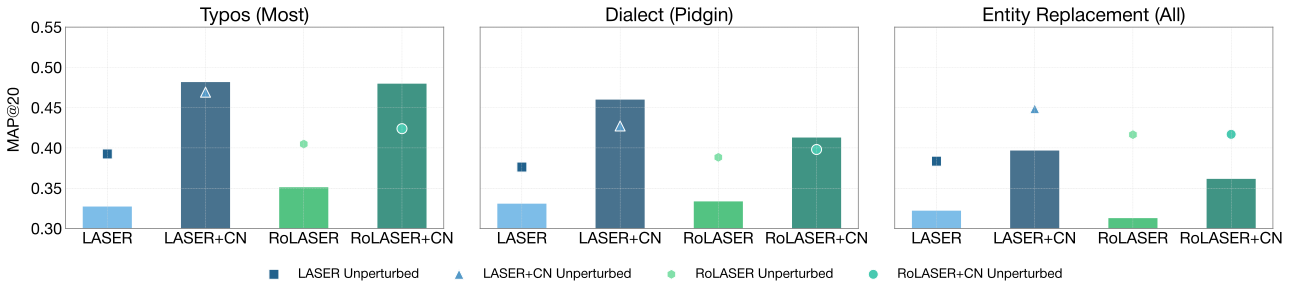

In [74]:
import matplotlib.pyplot as plt
import numpy as np
import cmcrameri.cm as cmc
import matplotlib

# Set font globally to Helvetica Neue
matplotlib.rcParams['font.family'] = 'Helvetica Neue'
plt.rcParams.update({'font.size': 16})  # Global font size


def plot_all_comparisons(df, output_file='comparison_plot.pdf'):
    perturbations = df["Perturbation"].unique()
    num_perturbations = len(perturbations)
    
    # Create a horizontal subplot for each perturbation
    fig, axes = plt.subplots(1, num_perturbations, figsize=(6 * num_perturbations, 4), sharey=True)
    
    # Colormap and bar colors
    bar_colors = ['#5DADE2', '#1B4F72', '#28B463', '#117A65']  # Navy, Green, Light Blue, Medium Green
    scatter_colors = ['#21618C', '#5499C7', '#82E0AA', '#48C9B0']  # Contrasting colors for scatter markers
    y_ticks = np.arange(0.30, 0.56, 0.05)  # Adjust start, end, and step size as needed

    # Markers for shapes
    markers = ['s', '^', 'h', 'o']  # Cross, Triangle, Star, Circle
    
    # Loop through each perturbation and plot
    for ax, perturbation in zip(axes, perturbations):
        row = df[df["Perturbation"] == perturbation].iloc[0]
        
        # Define x positions for each bar
        x_labels = ['LASER', 'LASER+CN', 'RoLASER', 'RoLASER+CN']
        x_positions = np.arange(len(x_labels))
        
        # Unperturbed and perturbed data
        unperturbed = [
            row["Unpertubed-LASER"],
            row["Unpertubed-LASER+CN"],
            row["Unpertubed-RoLASER"],
            row["Unpertubed-RoLASER+CN"]
        ]
        perturbed = [
            row["Perturbed-LASER"],
            row["Perturbed-LASER+CN"],
            row["Perturbed-RoLASER"],
            row["Perturbed-RoLASER+CN"]
        ]
        
        # Bar width
        bar_width = 0.50
        
        # Plot each bar
        for i, (x, p, u, bar_color, scatter_color) in enumerate(zip(x_positions, perturbed, unperturbed, bar_colors, scatter_colors)):
            ax.bar(x, p, width=bar_width, color=bar_color, alpha=0.8)
            
            # Add a marker for unperturbed value
            ax.scatter(x, u, color=scatter_color, marker=markers[i], s=100, edgecolors='white', linewidth=1, label=f'{x_labels[i]} Unperturbed')
        
        # Add horizontal gridlines
        for y in y_ticks:
            ax.axhline(y=y, color='lightgray', linestyle='--', linewidth=0.3)
        
        for x in x_positions:
            ax.axvline(x=x, color='lightgray', linestyle='--', linewidth=0.3)
    
        
        # Set labels and title
        ax.set_title(f'{perturbation}')
        ax.set_xticks(x_positions)
        ax.set_xticklabels(x_labels)
        ax.set_yticks(y_ticks)
        ax.set_ylim(0.30, 0.55)

        # Set the box outline (spines) to grey
        for spine in ax.spines.values():
            spine.set_edgecolor('grey')
        
        ax.tick_params(axis='both', length=0)

    
    # Add a common y-axis label
    fig.text(-0.005, 0.5, 'MAP@20', va='center', rotation='vertical')
    
    # Add a shared legend
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=len(x_labels), fontsize='small', bbox_to_anchor=(0.5, -0.1), frameon=False)
    
    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    plt.savefig(output_file, format='pdf', bbox_inches='tight', dpi=300)
    
    # Show the combined plot
    plt.show()

# Call the function to plot all perturbations
plot_all_comparisons(df)


/tmp/ipykernel_3496842/4140691862.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('plasma', num_models)


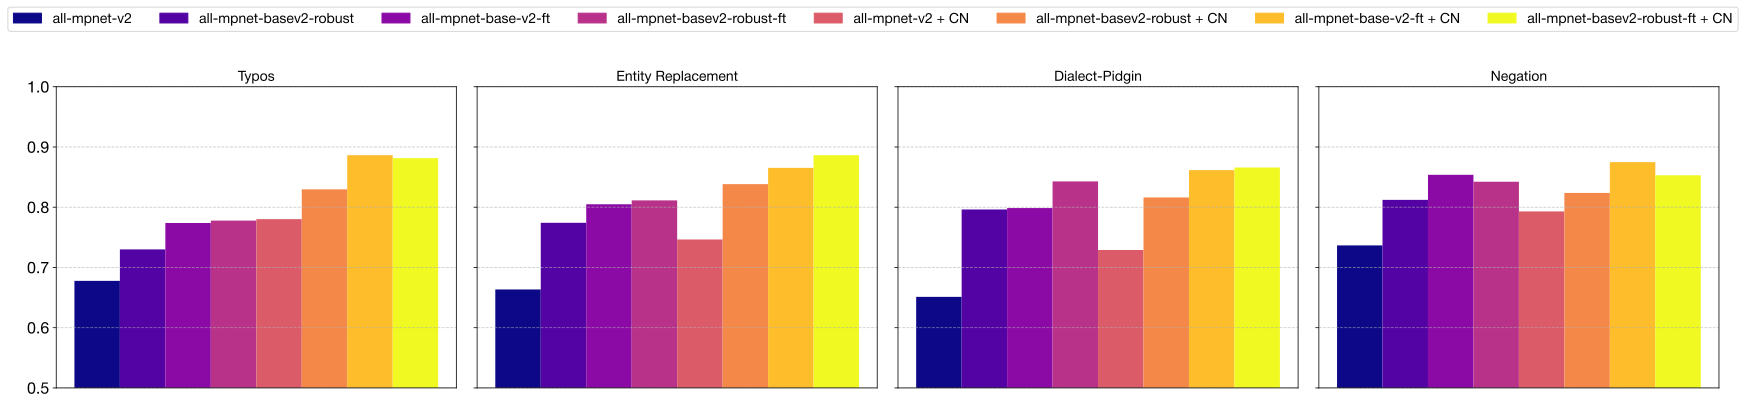

In [145]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Sample CSV data (simulated based on the description)
data = {
    "Model": [
        "all-mpnet-v2", "all-mpnet-basev2-robust", "all-mpnet-base-v2-ft", "all-mpnet-basev2-robust-ft",
        "all-mpnet-v2 + CN", "all-mpnet-basev2-robust + CN", "all-mpnet-base-v2-ft + CN", "all-mpnet-basev2-robust-ft + CN"
    ],
    "Typos": [0.6777792947, 0.7299715423, 0.7738389936, 0.7778453705, 0.7802357695, 0.8297682036, 0.8864141811, 0.8815278637],
    "Entity Replacement": [0.6634501966, 0.7741837164, 0.8048978672, 0.8113413255, 0.7465073234, 0.8383203952, 0.8653778943, 0.8863768749],
    "Dialect-Pidgin": [0.651213211, 0.7962632275, 0.798595063, 0.8428588505, 0.7289621542, 0.8162026703, 0.8615482391, 0.865947589],
    "Negation": [0.7365962491, 0.8122539556, 0.8538558851, 0.8422887173, 0.7930470993, 0.8236963299, 0.8748762499, 0.8531178844]
}

# Convert to DataFrame
df = pd.DataFrame(data)

def plot_perturbations_no_xlabels(df, output_file='perturbations_no_xlabels.pdf'):
    categories = ["Typos", "Entity Replacement", "Dialect-Pidgin", "Negation"]
    num_categories = len(categories)
    num_models = len(df["Model"])
    
    # Define color map for the models
    cmap = cm.get_cmap('plasma', num_models)
    colors = [cmap(i) for i in range(num_models)]

    # Create subplots for each perturbation type
    fig, axes = plt.subplots(1, num_categories, figsize=(6 * num_categories, 5), sharey=True)
    bar_width = 1.0  # Full-width bars for no spacing
    x_positions = np.arange(len(df["Model"]))  # X positions for each bar group

    for ax, category in zip(axes, categories):
        for i, model in enumerate(df["Model"]):
            ax.bar(x_positions[i], df[category][i], color=colors[i], width=bar_width, align='center', label=model if ax == axes[0] else "")
        ax.set_title(category, fontsize=14)
        ax.set_xticks([])  # Remove x-axis labels
        # ax.set_ylabel("Score", fontsize=12)
        ax.set_ylim(0.5, 1)
        ax.grid(axis='y', linestyle='--', alpha=0.7)



    # Add a single legend
    handles = [plt.Rectangle((0, 0), 1, 1, color=colors[i]) for i in range(num_models)]
    fig.legend(handles, df["Model"], loc='upper center', ncol=num_models, bbox_to_anchor=(0.5, 1.15), fontsize=14)

    # Adjust layout and save
    plt.tight_layout()
    # plt.savefig(output_file, format='pdf', bbox_inches='tight', dpi=300)
    plt.show()

# Call the function to create the plot without x-axis labels
plot_perturbations_no_xlabels(df)

/tmp/ipykernel_3496842/3447582077.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('inferno', len(df))


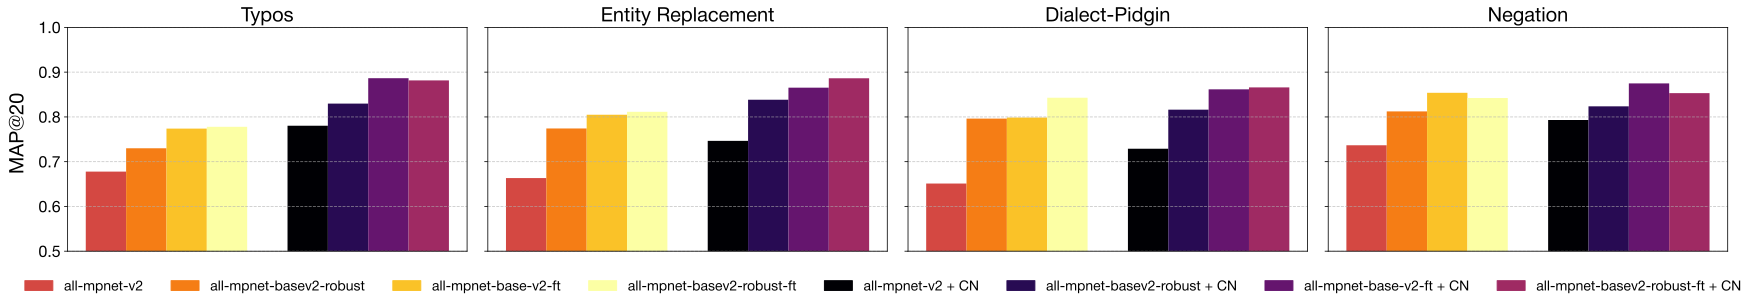

In [ ]:
def plot_perturbations_no_spacing_in_groups(df, output_file='perturbations_no_spacing_in_groups.pdf'):
    categories = ["Typos", "Entity Replacement", "Dialect-Pidgin", "Negation"]
    num_categories = len(categories)
    
    # Split the data into without CN and with CN
    df_no_cn = df.iloc[:4]
    df_with_cn = df.iloc[4:]
    
    # Define color map for the models
    cmap = cm.get_cmap('virdis', len(df))
    colors_no_cn = [cmap(i + len(df_no_cn)) for i in range(len(df_with_cn))] 
    colors_with_cn = [cmap(i) for i in range(len(df_no_cn))] 

    # Create subplots for each perturbation type
    fig, axes = plt.subplots(1, num_categories, figsize=(6 * num_categories, 4), sharey=True)
    bar_width = 1.0  # Bar width
    x_spacing = 2.0 # Spacing between groups=

    for ax, category in zip(axes, categories):
        # Add bars for models without CN
        x_positions_no_cn = np.arange(len(df_no_cn))
        for i, model in enumerate(df_no_cn["Model"]):
            ax.bar(x_positions_no_cn[i], df_no_cn[category].iloc[i], color=colors_no_cn[i], width=bar_width, align='center', label=model if ax == axes[0] else "")

        # Add bars for models with CN, placed after a gap
        x_positions_with_cn = x_positions_no_cn[-1] + x_spacing + np.arange(len(df_with_cn))
        for i, model in enumerate(df_with_cn["Model"]):
            ax.bar(x_positions_with_cn[i], df_with_cn[category].iloc[i], color=colors_with_cn[i], width=bar_width, align='center', label=model if ax == axes[0] else "")
        
        # Add titles and format axes
        ax.set_title(category, fontsize=20)
        ax.set_ylim(0.5, 1)
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        ax.set_xticks([])

    all_colors = colors_no_cn + colors_with_cn
    
    # Add a single legend
    handles = [plt.Rectangle((0, 0), 1, 1, color=all_colors[i]) for i in range(len(all_colors))]
    fig.legend(handles, df["Model"], loc='lower center', ncol=len(df), bbox_to_anchor=(0.5, -0.1), fontsize=14, frameon=False)
     # Add a common y-axis label
    fig.text(-0.007, 0.5, 'MAP@20', va='center', rotation='vertical', fontdict={'fontsize': 20})

    # Adjust layout and save
    plt.tight_layout()
    # plt.savefig(output_file, format='pdf', bbox_inches='tight', dpi=300)
    plt.show()

# Call the function to create the plot with no spacing within each group
plot_perturbations_no_spacing_in_groups(df)


In [23]:
# Implement logic to create parallel dataset sentences for each perturbation type
# Load the generations from GPT4o
perturbation_path = '/home/kebl7383/claim-matching-robustness/experiments/named_entity_replacement/gpt4o/clef2021-checkthat-task2a--english/train_worstcase_named_entity_replacements_verified.jsonl'

verified_df = pd.read_json(perturbation_path, lines=True)

def parse_rewritten_tweets(text):
    """
    Parses a given string of rewritten tweets into a list of individual tweets.

    Args:
        text (str): The input string containing rewritten tweets.

    Returns:
        list: A list of individual rewritten tweets.
    """
    # Split the text by lines and filter out any empty lines
    lines = [line.strip() for line in text.split("\n") if line.strip()]

    # Extract tweets after the colon ": " in lines that start with "Rewritten Tweet"
    tweets = [
        line.split(": ", 1)[1]
        for line in lines
        if line.startswith("Rewritten Tweet") and ": " in line
    ]

    return tweets


def parse_rewritten_tweets(text):
    """
    Parses a given string of rewritten tweets into a list of individual tweets.

    Args:
        text (str): The input string containing rewritten tweets.

    Returns:
        list: A list of individual rewritten tweets.
    """
    # Handle cases where the text may not have proper newlines between tweets
    tweets = []
    for segment in text.split("Rewritten Tweet"):
        # Ignore empty segments or ones without valid content
        if not segment.strip():
            continue
        # Extract the tweet number and content after ":"
        parts = segment.split(":", 1)
        if len(parts) > 1:
            tweet = parts[1].replace("\n", "").replace("\\n", "").strip()
            tweets.append(tweet)
    return tweets

In [24]:
import json 
import random

In [25]:
sample_response = verified_df.sample(n=1)['rewrites'].values[0]
parse_rewritten_tweets(sample_response)

['Mainstream media portrayed my meme as showing the MAGA Express "running over" a journalist. #FakeHeadlines‼️ The journalist is trying to stop it - feet popping ties.',
 'Corporate media depicted my meme of the Freedom Locomotive "running over" a news correspondent. #FalseNarrative‼️ The news correspondent is trying to block it - feet popping ties.',
 'The press claimed my meme showed the Liberty Train "running over" a news anchor. #BogusReport‼️ The news anchor is attempting to halt it - feet popping ties.',
 'The media portrayed my meme of the Patriot Train "running over" a broadcaster. #UntrueReport‼️ The broadcaster is trying to stop it - feet popping ties.',
 'News outlets depicted my meme as showing the USA Train "running over" a TV reporter. #IncorrectStory‼️ The TV reporter is trying to block it - feet popping ties.']

In [26]:
perturbed_claims = []
for idx, row in verified_df.iterrows():
    rewrites = parse_rewritten_tweets(str(row["rewrites"]))
    # If json loads fails, skip the row
    try:
        verified_labels = json.loads(row["verification"])["labels"]
    except:
        continue
    # Get indices where the label is 1
    verified_idx = [
        idx for idx, label in enumerate(verified_labels) if label == 1
    ]
    # Loop through the verified indices
    for idx in verified_idx:
        # Add the original claim and rewritten claim to their respective lists
        orig_json = {
            "query_id": row["query_id"],
            "original_query": row["query"],
            "perturbed_query": rewrites[idx],
        }
        perturbed_claims.append(orig_json)

In [27]:
len(perturbed_claims)

1853

In [28]:
entity_replaced_df = pd.DataFrame(perturbed_claims)

In [29]:
entity_replaced_df.head()

,query_id,original_query,perturbed_query
0,tweet-sno-2,A number of fraudulent text messages informing individuals they have been selected for a military draft have circulated throughout the country this week.,Several fake text messages claiming individuals have been chosen for conscription have spread across the nation this week.
1,tweet-sno-2,A number of fraudulent text messages informing individuals they have been selected for a military draft have circulated throughout the country this week.,A series of bogus messages stating people have been drafted have been circulating around the country this past week.
2,tweet-sno-2,A number of fraudulent text messages informing individuals they have been selected for a military draft have circulated throughout the country this week.,Numerous fraudulent texts suggesting citizens have been picked for conscription have been distributed nationwide this week.
3,tweet-sno-2,A number of fraudulent text messages informing individuals they have been selected for a military draft have circulated throughout the country this week.,A wave of phony text alerts announcing individuals have been drafted into military service has been moving through the nation this week.
4,tweet-sno-2,A number of fraudulent text messages informing individuals they have been selected for a military draft have circulated throughout the country this week.,Several deceptive texts indicating people have been chosen for enlistment have been spreading throughout the country this week.


In [30]:
# Load the dialect changes
perturbation_path = "/home/kebl7383/claim-matching-robustness/experiments/dialect/gpt4o/clef2021-checkthat-task2a--english/train_dialect_rewrites_verified.jsonl"

In [31]:
dialect_verified_df = pd.read_json(perturbation_path, lines=True)

In [32]:
def parse_rewritten_old_tweets(text):
    """
    Parses a given string of rewritten tweets into a list of individual tweets.

    Args:
        text (str): The input string containing rewritten tweets.

    Returns:
        list: A list of individual rewritten tweets.
    """
    # Split the text by lines and filter out any empty lines
    lines = [line.strip() for line in text.split("\n") if line.strip()]

    # Extract tweets after the colon ": " in lines that start with "Rewritten Tweet"
    tweets = [
        line.split(": ", 1)[1]
        for line in lines
        if line.startswith("Rewritten Tweet") and ": " in line
    ]

    return tweets

In [33]:
dialect_perturbed_claims = []
for idx, row in dialect_verified_df.iterrows():
    rewrites = parse_rewritten_old_tweets(str(row["rewrites"]))
    # If json loads fails, skip the row
    try:
        verified_labels = json.loads(row["verification"])["labels"]
    except:
        continue
    # Get indices where the label is 1
    verified_idx = [
        idx for idx, label in enumerate(verified_labels) if label == 1
    ]
    # Loop through the verified indices
    for idx in verified_idx:
        # Add the original claim and rewritten claim to their respective lists
        orig_json = {
            "query_id": row["query_id"],
            "original_query": row["query"],
            "perturbed_query": rewrites[idx],
        }
        dialect_perturbed_claims.append(orig_json)

In [34]:
dialect_perturbed_df = pd.DataFrame(dialect_perturbed_claims)

In [35]:
dialect_perturbed_df.tail()

,query_id,original_query,perturbed_query
3519,tweet-sno-997,#BreakingNews: We’re launching an exciting new savoury #condom range – Eggplant flavour! ? #CondomEmoji,#BreakingNews: We a launch exciting new savoury #condom range – Eggplant flavour! ? #CondomEmoji
3520,tweet-sno-998,Phyllis Schlafly said “We’ll have a woman President over my dead body.” God accepts the deal.,Phyllis Schlafly be like “We’ll get a woman President over my dead body.” God say deal.
3521,tweet-sno-998,Phyllis Schlafly said “We’ll have a woman President over my dead body.” God accepts the deal.,Phyllis Schlafly talk say “Woman go be President over my dead body.” God gree am.
3522,tweet-sno-998,Phyllis Schlafly said “We’ll have a woman President over my dead body.” God accepts the deal.,"Aiyah, Phyllis Schlafly say “Woman President over my dead body.” God take dat deal."
3523,tweet-sno-998,Phyllis Schlafly said “We’ll have a woman President over my dead body.” God accepts the deal.,Phyllis Schlafly seh “Woman fi be President over my dead body.” God agree to dat.


In [36]:
dialect_perturbed_df.shape, entity_replaced_df.shape

((3524, 3), (1853, 3))

In [37]:
# Load typos
typos_perturbation_path = "/home/kebl7383/claim-matching-robustness/experiments/typos/gpt4o/clef2021-checkthat-task2a--english/train_llm_typos_verified.jsonl"

In [38]:
typos_verified_df = pd.read_json(typos_perturbation_path, lines=True)

In [39]:
typos_perturbed_claims = []
for idx, row in typos_verified_df.iterrows():
    rewrites = parse_rewritten_old_tweets(str(row["rewrites"]))
    # If json loads fails, skip the row
    try:
        verified_labels = json.loads(row["verification"])["labels"]
    except:
        continue
    # Get indices where the label is 1
    verified_idx = [
        idx for idx, label in enumerate(verified_labels) if label == 1
    ]
    # Loop through the verified indices
    for idx in verified_idx:
        # Add the original claim and rewritten claim to their respective lists
        orig_json = {
            "query_id": row["query_id"],
            "original_query": row["query"],
            "perturbed_query": rewrites[idx],
        }
        typos_perturbed_claims.append(orig_json)

In [40]:
typos_perturbed_df = pd.DataFrame(typos_perturbed_claims) 

In [41]:
typos_perturbed_df.shape

(3977, 3)

In [42]:
(dialect_perturbed_df.shape[0] + entity_replaced_df.shape[0] + typos_perturbed_df.shape[0])

9354

In [43]:
# Load the negation changes
negation_perturbation_path = "/home/kebl7383/claim-matching-robustness/experiments/negation/gpt4o/clef2021-checkthat-task2a--english/train_worstcase_negation_verified.jsonl"

In [44]:
negation_verified_df = pd.read_json(negation_perturbation_path, lines=True)

In [45]:
import re

In [46]:
def parse_claims(markdown_json_string):
    """
    Parses a JSON string formatted with Markdown-style backticks and returns the list of claims.

    Args:
        markdown_json_string (str): A string containing JSON wrapped in Markdown backticks.

    Returns:
        list: A list of claims from the JSON or an empty list if no claims are found.
    """
    try:
        # Remove Markdown formatting (backticks and optional language labels)
        cleaned_json_string = re.sub(
            r"```(?:json)?\n", "", markdown_json_string.strip()
        ).strip("`")

        # Parse the cleaned JSON string
        parsed_data = json.loads(cleaned_json_string)

        # Return the list of claims
        return parsed_data.get("negated_claims", [])
    except (json.JSONDecodeError, AttributeError) as e:
        # Handle errors gracefully and return an empty list
        print(f"Error parsing JSON: {e}")
        return []

In [47]:
test = negation_verified_df.sample(n=1)['rewrites'].values[0]
parse_claims(test)

['It is not false that there are no spine-chilling visuals of the ride collapsing at #kankaria#adventure#park in #Ahmedabad with 26 injured and 2 deaths and one critical.',
 'It is not false that 26 were not injured and 2 did not die in the spine-chilling visuals of the ride collapsing at #kankaria#adventure#park in #Ahmedabad.',
 'Spine-chilling visuals do not show 26 injured and 2 deaths and one critical in a ride collapse at #kankaria#adventure#park in #Ahmedabad.',
 'It is not true that the ride at #kankaria#adventure#park in #Ahmedabad did not collapse causing 26 injuries and 2 deaths and one critical.',
 'It is not false that there are no deaths and injuries in the spine-chilling visuals of the ride collapse at #kankaria#adventure#park in #Ahmedabad.']

In [48]:
negation_perturbed_claims = []
for idx, row in negation_verified_df.iterrows():
    print(f'We are here {idx}')
    rewrites = parse_claims(row["rewrites"])
    # If json loads fails, skip the row
    try:
        verified_labels = json.loads(row["verification"])["labels"]
    except:
        continue
    # Get indices where the label is 1
    verified_idx = [
        idx for idx, label in enumerate(verified_labels) if label == 1
    ]
    # Loop through the verified indices
    for idx in verified_idx:
        # Add try catch block to handle errors
        try:
            # Add the original claim and rewritten claim to their respective lists
            orig_json = {
                "query_id": row["query_id"],
                "original_query": row["query"],
                "perturbed_query": rewrites[idx],
            }
            negation_perturbed_claims.append(orig_json)
        except:
            continue

We are here 0
We are here 1
We are here 2
We are here 3
We are here 4
We are here 5
We are here 6
We are here 7
We are here 8
Error parsing JSON: Expecting value: line 1 column 1 (char 0)
We are here 9
We are here 10
We are here 11
We are here 12
We are here 13
We are here 14
We are here 15
We are here 16
We are here 17
We are here 18
We are here 19
We are here 20
We are here 21
We are here 22
We are here 23
Error parsing JSON: Unterminated string starting at: line 7 column 1 (char 1148)
We are here 24
We are here 25
We are here 26
We are here 27
We are here 28
We are here 29
We are here 30
We are here 31
We are here 32
We are here 33
We are here 34
We are here 35
We are here 36
We are here 37
We are here 38
We are here 39
We are here 40
We are here 41
We are here 42
We are here 43
We are here 44
We are here 45
We are here 46
We are here 47
We are here 48
We are here 49
We are here 50
We are here 51
We are here 52
We are here 53
We are here 54
We are here 55
We are here 56
We are here 

In [49]:
len(negation_perturbed_claims)

2189

In [50]:
negation_perturbed_df = pd.DataFrame(negation_perturbed_claims)

In [51]:
(dialect_perturbed_df.shape[0] + entity_replaced_df.shape[0] + typos_perturbed_df.shape[0] + negation_perturbed_df.shape[0])

11543

In [52]:
all_dfs = pd.concat([dialect_perturbed_df, entity_replaced_df, typos_perturbed_df, negation_perturbed_df])

In [53]:
all_dfs.shape

(11543, 3)

In [54]:
all_dfs.head()

,query_id,original_query,perturbed_query
0,tweet-sno-2,A number of fraudulent text messages informing individuals they have been selected for a military draft have circulated throughout the country this week.,A bunch of fake texts sayin' folks been picked for the draft done spread 'round the country dis week.
1,tweet-sno-2,A number of fraudulent text messages informing individuals they have been selected for a military draft have circulated throughout the country this week.,"Plenty fake message dey go round dis week, dem dey talk say dem select you for army draft."
2,tweet-sno-2,A number of fraudulent text messages informing individuals they have been selected for a military draft have circulated throughout the country this week.,"Wah, got many fake SMS say people kena chosen for army draft, spreading around leh."
3,tweet-sno-2,A number of fraudulent text messages informing individuals they have been selected for a military draft have circulated throughout the country this week.,"Nuff fraudulent message dem a go 'round dis week, say people pick fi military draft."
4,tweet-sno-3,"Fact check: The U.S. Army is NOT contacting anyone regarding the draft. If you are receiving texts, phone calls or direct messages about a military draft, they are not official communications from the U.S. Army","U.S. Army ain't hittin' nobody up 'bout no draft. If you gettin' messages, dem ain't official."


In [55]:
all_dfs.to_csv('train_perturbed_queries_lite.csv', index=False)

In [56]:
from itertools import combinations

In [57]:
# Function to generate combinatorial pairs
def generate_combinatorial_pairs(df):
    result = []
    for query_id, group in df.groupby("query_id"):
        # Generate all combinations of perturbed_query pairs
        perturbed_queries = group["perturbed_query"].tolist()
        pairs = combinations(perturbed_queries, 2)
        for pair in pairs:
            result.append({
                "query_id": query_id,
                "original_query": pair[0],
                "perturbation_query": pair[1]
            })
    return pd.DataFrame(result)

# Generate the test file
test_df = generate_combinatorial_pairs(all_dfs)

In [58]:
test_df.shape

(70954, 3)

In [59]:
test_df[test_df["query_id"] == "tweet-sno-4"]  

,query_id,original_query,perturbation_query
23587,tweet-sno-4,"Dem catch US drone strike on Soleimani pon camera, yah. #IranUsa",Dem capture US drone attack wey hit Soleimani for cam. #IranUsa
23588,tweet-sno-4,"Dem catch US drone strike on Soleimani pon camera, yah. #IranUsa","Wah, US drone attack on Soleimani kenna caught on video leh. #IranUsa"
23589,tweet-sno-4,"Dem catch US drone strike on Soleimani pon camera, yah. #IranUsa","US drone strike pon Soleimani seen on di camera, seen. #IranUsa"
23590,tweet-sno-4,"Dem catch US drone strike on Soleimani pon camera, yah. #IranUsa",The American drone strike on #Qassem caught on camera.#TehranWashington
23591,tweet-sno-4,"Dem catch US drone strike on Soleimani pon camera, yah. #IranUsa",The US drone attack on #IranianGeneral caught on video.#PersiaUSA
...,...,...,...
23735,tweet-sno-4,It is not false that the US drone attack on #Soleimani was caught on camera.,It is not true that the US drone attack on #Soleimani was not caught on camera.
23736,tweet-sno-4,It is not false that the US drone attack on #Soleimani was caught on camera.,It is not untrue that a US-ordered drone strike on #Soleimani was recorded.
23737,tweet-sno-4,The US drone attack on #Soleimani was not caught off camera.,It is not true that the US drone attack on #Soleimani was not caught on camera.
23738,tweet-sno-4,The US drone attack on #Soleimani was not caught off camera.,It is not untrue that a US-ordered drone strike on #Soleimani was recorded.


In [60]:
# Save output as CSV
test_df.to_csv('train_perturbed_queries_full.csv', index=False)

In [61]:
import pandas as pd

In [62]:
# Load the lite file
lite_df = pd.read_csv('train_perturbed_queries_lite.csv')

In [63]:
lite_df.head()

,query_id,original_query,perturbed_query
0,tweet-sno-2,A number of fraudulent text messages informing individuals they have been selected for a military draft have circulated throughout the country this week.,A bunch of fake texts sayin' folks been picked for the draft done spread 'round the country dis week.
1,tweet-sno-2,A number of fraudulent text messages informing individuals they have been selected for a military draft have circulated throughout the country this week.,"Plenty fake message dey go round dis week, dem dey talk say dem select you for army draft."
2,tweet-sno-2,A number of fraudulent text messages informing individuals they have been selected for a military draft have circulated throughout the country this week.,"Wah, got many fake SMS say people kena chosen for army draft, spreading around leh."
3,tweet-sno-2,A number of fraudulent text messages informing individuals they have been selected for a military draft have circulated throughout the country this week.,"Nuff fraudulent message dem a go 'round dis week, say people pick fi military draft."
4,tweet-sno-3,"Fact check: The U.S. Army is NOT contacting anyone regarding the draft. If you are receiving texts, phone calls or direct messages about a military draft, they are not official communications from the U.S. Army","U.S. Army ain't hittin' nobody up 'bout no draft. If you gettin' messages, dem ain't official."


In [64]:
from sklearn.model_selection import train_test_split

# Step 1: Get unique query IDs
unique_query_ids = lite_df['query_id'].unique()

# Step 2: Split the unique IDs into train and evaluation sets
train_ids, eval_ids = train_test_split(unique_query_ids, test_size=0.10, random_state=42)

# Step 3: Split the original DataFrame based on the IDs
train_df = lite_df[lite_df['query_id'].isin(train_ids)]
eval_df = lite_df[lite_df['query_id'].isin(eval_ids)]

In [65]:
# Display the resulting DataFrames
train_df.shape, eval_df.shape

((10466, 3), (1077, 3))

In [66]:
eval_df.head()

,query_id,original_query,perturbed_query
91,tweet-sno-30,"The Trump campaign photoshopping a MAGA hat on a photo taken in London of a PoC British national and trying to pass it off as, “see, black people in America love Trump!” is simply *chef kiss*. Well done, /.","Trump campaign done photoshop MAGA hat on London black man pic sayin’ “see, Black folks in America love Trump!” *chef kiss* Bravo, /."
92,tweet-sno-30,"The Trump campaign photoshopping a MAGA hat on a photo taken in London of a PoC British national and trying to pass it off as, “see, black people in America love Trump!” is simply *chef kiss*. Well done, /.","Trump campaign don change foto, put MAGA hat for head of London black man, dey talk say “see as black people for America love Trump!” *chef kiss* Nice one, /."
93,tweet-sno-30,"The Trump campaign photoshopping a MAGA hat on a photo taken in London of a PoC British national and trying to pass it off as, “see, black people in America love Trump!” is simply *chef kiss*. Well done, /.","Wah, Trump campaign photoshop MAGA hat on London de people head, try say “see, black people in America love Trump!” *chef kiss* Well done, /."
94,tweet-sno-30,"The Trump campaign photoshopping a MAGA hat on a photo taken in London of a PoC British national and trying to pass it off as, “see, black people in America love Trump!” is simply *chef kiss*. Well done, /.","Trump campaign a photoshop one MAGA hat pon di head of one black British man an’ tek it fi seh, “see, black people in America love Trump!” *chef kiss* Big up, /."
119,tweet-sno-37,"The Odessa Shooter’s name is Seth Ator, a Democrat Socialist who had a Beto sticker on his truck.","Odessa shooter name be Seth Ator, he be Democrat Socialist, got Beto sticker on him truck."


In [67]:
# Save lite train and eval files
train_df.to_csv('train_perturbed_queries_lite_train.csv', index=False)
eval_df.to_csv('train_perturbed_queries_lite_eval.csv', index=False)

In [69]:
full_df = pd.read_csv('train_perturbed_queries_full.csv')

In [70]:
from sklearn.model_selection import train_test_split

# Step 1: Get unique query IDs
unique_query_ids = full_df['query_id'].unique()

# Step 2: Split the unique IDs into train and evaluation sets
train_ids, eval_ids = train_test_split(unique_query_ids, test_size=0.10, random_state=42)

# Step 3: Split the original DataFrame based on the IDs
full_train_df = full_df[full_df['query_id'].isin(train_ids)]
full_eval_df = full_df[full_df['query_id'].isin(eval_ids)]

In [71]:
full_train_df.shape, full_eval_df.shape

((63412, 3), (7542, 3))

In [72]:
# Save lite train and eval files
train_df.to_csv('train_perturbed_queries_full_train.csv', index=False)
eval_df.to_csv('train_perturbed_queries_full_eval.csv', index=False)